## Assignment 02 – Cryptocurrency Portfolio

#### Group 7 
#### Yifan(Jake) Zhu yz1049
#### Sirui Xie sx115
#### Congfei Yin cy478
Please use jupyter notebook to implement the following structures. You will upload a Jupyter Notebook and an HTML or a PDF file (exported from the notebook) to the canvas portal. There is no restriction on what IDE to use, but a cloud IDE like Google Collab or AWS Sagemaker would be your best choice if you have a low-power/configuration computer. All the assignments are graded holistically. All assignments in the class are group assignments (if you prefer, you can choose to work independently).

This assignment will be graded out of 75 points. Each assignment submission page lists assignment open and close dates with grace periods (48 hours). They are also listed on the syllabus.

Since Blockchain is open-sourced, you will find most of the code online with a complete solution to most assignments. Please refrain from copy-pasting. The goal is to learn to build one from scratch to understand the technology. I will keep an eye on the submissions. Please list the source after the code to avoid plagiarism and copying issues.

The entire assignment is recorded and posted on Canvas under Panopto. You should go over the video and modify the code accordingly.

### 1       Importing data and packages

In [1]:
import pandas_datareader.data as pdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import requests
plt.style.use('bmh')

### 2       Gather Coin token ID information from Coinmarket, Binance, or Coinbase.

You will need to search on any of the three websites to get the token IDs. The video shows how to do it through Binance and coin market cap. A slight difference between the Binance token and the coin market token is that the Binance token adds BUSD or USDT at the end, while the CoinMarket token does not. For example, Bitcoin is represented as BTC in CoinMarket and BTCBUSD or BTCUSDT in Binance. This represents the currency conversion to a stablecoin instead of a fiat currency.

For the sake of this bit, you can choose any 30 cryptocurrencies except Bitcoin and Ethereum. Here are the categories to select from

1. High market cap group - this will include the most widely traded coins. We will use the top 5 coins, namely, Bitcoin (BTC-USD), Ethereum (ETH-USD), Litecoin (LTC-USD), Teather (USDT), and BNB (BNB-USD).

In [2]:
high_market_cap = ['BTC','ETH','USDT','LTC','USDT','BNB']

2. Mid-market cap group will include coins with a market cap between 1 billion and 20 billion. We will use the top 5 coins, namely, Cardano (ADA-USD), Polygon (MATIC-USD), Dogecoin (DOGE-USD), Ripple (XRP-USD), and Binance USD (BUSD).

In [3]:
mid_market_cap = ['ADA','MATIC','DOGE','XRP','BUSD']

3. The low market cap group will include coins with a market cap between 100 million and 1 billion. We will use the top 20 coins.
Make sure to list the ticker ids in a list of strings

In [4]:
low_market_cap = ['GRT','ALGO','USDD','STX','EOS','EGLD','INJ','FRAX','RNDR','NEO','AXS','XEC','GT','CETH','USDP','FLOW','APE','KCS','CHZ','IOTA']

#### 2.1        Getting Data From Binance
Create a function that takes ticker interval, start_time, and end_time as input. We want to get all the data for the selected tickers and save them in data chosen frames. There is a way to automate this by using a function as well.

1. For each coin/token, you will get a dataframe of daily movements from start to end. The date and time are set as the index. Close, Symbol, and index are the most critical columns, and we want to subset them in a" coins" dataframe for all the coins.

Here, we use coingecko to grab the coin data. Based on the above 30 coins from coin market cap, we adjust the coin_id to use for coingecko api. And for the below calculation, we select the time interval from 2023-06-27 to 2023-09-27

In [5]:
from time import sleep

def get_coin_data(coin_id, from_timestamp, to_timestamp, currency='usd'):
    base_url = f"https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart/range"
    params = {
        'vs_currency': currency,
        'from': from_timestamp,
        'to': to_timestamp
    }

    response = requests.get(base_url, params=params)
    response.raise_for_status()

    data = response.json()
    df = pd.DataFrame(data['prices'], columns=['Date', 'Close'])
    df['Date'] = pd.to_datetime(df['Date'], unit='ms')
    df.set_index('Date', inplace=True)
    df['Symbol'] = coin_id.upper()
    
    return df

In [6]:
tokens = high_market_cap + mid_market_cap + low_market_cap
coin_id=['bitcoin','ethereum','litecoin','tether','binancecoin','cardano','matic-network','dogecoin','ripple','binance-usd','the-graph','algorand','usdd','blockstack','eos','elrond-erd-2','injective-protocol','frax','render-token','neo','axie-infinity','ecash','gatechain-token','compound-ether','paxos-standard','flow','apecoin','kucoin-shares','chiliz','iota']

start_time = int(pd.Timestamp('2023-06-27').timestamp())
end_time = int(pd.Timestamp('2023-09-27').timestamp())

In [7]:
all_coins = []

for i in range(len(coin_id)):

    coin_data = get_coin_data(coin_id[i], start_time, end_time)
    all_coins.append(coin_data)
    sleep(30)
  # Sleep for 60 seconds to respect API rate limits


In [8]:
# Sandbox website has different format, so we deall with it seperately
coin_id = "the-sandbox"
if coin_id:
        coin_data = get_coin_data(coin_id, start_time, end_time)
        all_coins.append(coin_data)
        sleep(60)  # Sleep for 60 seconds to respect API rate limits
else:
        print(f"Failed to get data for symbol: {symbol}")
coins = pd.concat(all_coins)

In [9]:
coins.head()

,Close,Symbol
Date,,
2023-06-27,30285.505064,BITCOIN
2023-06-28,30693.546356,BITCOIN
2023-06-29,30083.477245,BITCOIN
2023-06-30,30466.610457,BITCOIN
2023-07-01,30480.781482,BITCOIN


2. Rename close to "Coinname_closeprice." Replace the coin name with the name of the coin and token id.


#### 2.2        Combining the dataframe
The updated dataframe should have the index and close price of all the coins of interest. We will use this to calculate the efficient frontier for the portfolio.

In [10]:
Symbol = coins['Symbol'].unique()

In [11]:
coins_df = None
for i in range(30):
    symbol = Symbol[i]
    coin_name = tokens[i]
    coin_df = coins[coins['Symbol'] == symbol]
    new_col_name = f"{symbol}_{coin_name}_closeprice"
    coin_df.rename(columns={'Close': new_col_name}, inplace=True)
    coin_df.drop(columns=['Symbol'], inplace=True)
    if coins_df is None:
        coins_df = coin_df
    else:
        coins_df = coins_df.merge(coin_df,how = 'left', left_index=True, right_index=True)


/var/folders/lg/fk1yqx1j7z58x0dk25vm5rb00000gn/T/ipykernel_79539/2610017428.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coin_df.rename(columns={'Close': new_col_name}, inplace=True)
/var/folders/lg/fk1yqx1j7z58x0dk25vm5rb00000gn/T/ipykernel_79539/2610017428.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coin_df.drop(columns=['Symbol'], inplace=True)
/var/folders/lg/fk1yqx1j7z58x0dk25vm5rb00000gn/T/ipykernel_79539/2610017428.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [12]:
coins_df.head()

,BITCOIN_BTC_closeprice,ETHEREUM_ETH_closeprice,LITECOIN_USDT_closeprice,TETHER_LTC_closeprice,BINANCECOIN_USDT_closeprice,CARDANO_BNB_closeprice,MATIC-NETWORK_ADA_closeprice,DOGECOIN_MATIC_closeprice,RIPPLE_DOGE_closeprice,BINANCE-USD_XRP_closeprice,...,AXIE-INFINITY_NEO_closeprice,ECASH_AXS_closeprice,GATECHAIN-TOKEN_XEC_closeprice,COMPOUND-ETHER_GT_closeprice,PAXOS-STANDARD_CETH_closeprice,FLOW_USDP_closeprice,APECOIN_FLOW_closeprice,KUCOIN-SHARES_APE_closeprice,CHILIZ_KCS_closeprice,IOTA_CHZ_closeprice
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-27,30285.505064,1859.802420,87.242862,1.000250,236.170319,0.280616,0.645300,0.064770,0.479150,1.000565,...,5.800973,0.000024,4.240039,37.349704,1.000394,0.540887,2.325061,6.539588,0.077383,0.180039
2023-06-28,30693.546356,1890.012904,87.971243,0.999820,237.496341,0.286364,0.664397,0.065546,0.484370,0.999037,...,5.892852,0.000024,4.247014,37.928411,1.000239,0.545379,2.316848,6.568144,0.077503,0.183843
2023-06-29,30083.477245,1828.458336,83.090666,0.999451,230.498040,0.266987,0.614389,0.062562,0.464818,0.998411,...,5.531489,0.000022,4.202539,36.697418,1.000099,0.508966,2.198929,6.403128,0.072630,0.174586
2023-06-30,30466.610457,1853.445246,84.855730,1.000383,233.406202,0.275736,0.624204,0.063458,0.474588,1.000003,...,5.657325,0.000023,4.222562,37.178836,1.000045,0.517462,2.236530,6.415872,0.074128,0.177849
2023-07-01,30480.781482,1934.045714,107.962168,0.999596,240.515441,0.286846,0.660604,0.066438,0.473648,0.999740,...,5.938318,0.000040,4.307001,38.824020,0.998574,0.542773,2.222757,6.594385,0.075688,0.182127


In [13]:
# Here we replace the NaN of BRIDGED-TETHER-LINEA to 0 as its launch date is 2023-08-14.
coins_df.fillna(0, inplace=True)

In [14]:
coins_df.head()

,BITCOIN_BTC_closeprice,ETHEREUM_ETH_closeprice,LITECOIN_USDT_closeprice,TETHER_LTC_closeprice,BINANCECOIN_USDT_closeprice,CARDANO_BNB_closeprice,MATIC-NETWORK_ADA_closeprice,DOGECOIN_MATIC_closeprice,RIPPLE_DOGE_closeprice,BINANCE-USD_XRP_closeprice,...,AXIE-INFINITY_NEO_closeprice,ECASH_AXS_closeprice,GATECHAIN-TOKEN_XEC_closeprice,COMPOUND-ETHER_GT_closeprice,PAXOS-STANDARD_CETH_closeprice,FLOW_USDP_closeprice,APECOIN_FLOW_closeprice,KUCOIN-SHARES_APE_closeprice,CHILIZ_KCS_closeprice,IOTA_CHZ_closeprice
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-27,30285.505064,1859.802420,87.242862,1.000250,236.170319,0.280616,0.645300,0.064770,0.479150,1.000565,...,5.800973,0.000024,4.240039,37.349704,1.000394,0.540887,2.325061,6.539588,0.077383,0.180039
2023-06-28,30693.546356,1890.012904,87.971243,0.999820,237.496341,0.286364,0.664397,0.065546,0.484370,0.999037,...,5.892852,0.000024,4.247014,37.928411,1.000239,0.545379,2.316848,6.568144,0.077503,0.183843
2023-06-29,30083.477245,1828.458336,83.090666,0.999451,230.498040,0.266987,0.614389,0.062562,0.464818,0.998411,...,5.531489,0.000022,4.202539,36.697418,1.000099,0.508966,2.198929,6.403128,0.072630,0.174586
2023-06-30,30466.610457,1853.445246,84.855730,1.000383,233.406202,0.275736,0.624204,0.063458,0.474588,1.000003,...,5.657325,0.000023,4.222562,37.178836,1.000045,0.517462,2.236530,6.415872,0.074128,0.177849
2023-07-01,30480.781482,1934.045714,107.962168,0.999596,240.515441,0.286846,0.660604,0.066438,0.473648,0.999740,...,5.938318,0.000040,4.307001,38.824020,0.998574,0.542773,2.222757,6.594385,0.075688,0.182127


### 3       Calculating the Efficient Frontier
To calculate an efficient frontier, we will need to calculate each coin's means, standard deviations, and covariances.

1. Calculate the mean of the dataframe generated in 2.2 using pd.df.mean() method


In [15]:
def calc_mean(df):
    return df.mean()

coin_mean = calc_mean(coins_df)
print(coin_mean)

BITCOIN_BTC_closeprice                28263.885521
ETHEREUM_ETH_closeprice                1769.281003
LITECOIN_USDT_closeprice                 79.464777
TETHER_LTC_closeprice                     0.999752
BINANCECOIN_USDT_closeprice             229.586652
CARDANO_BNB_closeprice                    0.279711
MATIC-NETWORK_ADA_closeprice              0.631771
DOGECOIN_MATIC_closeprice                 0.067525
RIPPLE_DOGE_closeprice                    0.571903
BINANCE-USD_XRP_closeprice                1.000008
THE-GRAPH_BUSD_closeprice                 0.101523
ALGORAND_GRT_closeprice                   0.106060
USDD_ALGO_closeprice                      0.998255
BLOCKSTACK_USDD_closeprice                0.558606
EOS_STX_closeprice                        0.666771
ELROND-ERD-2_EOS_closeprice              29.792218
INJECTIVE-PROTOCOL_EGLD_closeprice        7.703602
FRAX_INJ_closeprice                       0.998127
RENDER-TOKEN_FRAX_closeprice              1.682608
NEO_RNDR_closeprice            

2. Calculate the covariance matrix of the dataframe generated in 2.2 using pd.df.cov() method


In [16]:
def calc_cov(df):
    return df.cov()

coin_cov = calc_cov(coins_df)
print(coin_cov)

                                    BITCOIN_BTC_closeprice  \
BITCOIN_BTC_closeprice                        3.522930e+06   
ETHEREUM_ETH_closeprice                       2.273125e+05   
LITECOIN_USDT_closeprice                      2.665245e+04   
TETHER_LTC_closeprice                         1.458214e-01   
BINANCECOIN_USDT_closeprice                   2.470270e+04   
CARDANO_BNB_closeprice                        3.961869e+01   
MATIC-NETWORK_ADA_closeprice                  1.496550e+02   
DOGECOIN_MATIC_closeprice                     6.671179e+00   
RIPPLE_DOGE_closeprice                        8.616405e+01   
BINANCE-USD_XRP_closeprice                    1.649855e-01   
THE-GRAPH_BUSD_closeprice                     2.350034e+01   
ALGORAND_GRT_closeprice                       1.827784e+01   
USDD_ALGO_closeprice                          1.607647e+00   
BLOCKSTACK_USDD_closeprice                    1.579464e+02   
EOS_STX_closeprice                            1.465806e+02   
ELROND-E

3. Use the function in the video to generate a complete crypto portfolio for $10,000.

In [30]:
def simulate_portfolios(df, num_portfolios, mean_daily_returns, cov_matrix):
    num_assets = len(df.columns)
    results = np.zeros((3, num_portfolios))
    
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        
        # Expected portfolio return
        portfolio_return = np.sum(mean_daily_returns * weights) * 252
        
        # Expected portfolio volatility
        portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
        
        # Store results in results array
        results[0,i] = portfolio_return
        results[1,i] = portfolio_stddev
        
        # Portfolio Sharpe ratio, assuming risk-free rate is close to 0
        results[2,i] = results[0,i] / results[1,i]

    return results

In [32]:
num_portfolios = 10000
results = simulate_portfolios(coins_df, num_portfolios, coin_mean, coin_cov)
print(results)

[[3.17353108e+04 3.39121288e+04 3.57098889e+05 ... 2.76607079e+05
  1.67579100e+05 7.96931262e+04]
 [1.39851564e+02 1.53334364e+02 1.50211480e+03 ... 1.16315780e+03
  7.04578967e+02 3.39302425e+02]
 [2.26921387e+02 2.21164571e+02 2.37730757e+02 ... 2.37807011e+02
  2.37842893e+02 2.34873435e+02]]


### 4       Locate the Best portfolios
The percentages returned from the best portfolio search represent the total assets added to each coin from the $10,000.

4.1        Locate the position of the portfolio with the highest Sharpe Ratio

In [44]:
results_df = pd.DataFrame(results.T, columns=['return','stddev','sharpe'])
results_df.head(15)

,return,stddev,sharpe
0,31735.310793,139.851564,226.921387
1,33912.128766,153.334364,221.164571
2,357098.889069,1502.114800,237.730757
3,63934.997859,275.297248,232.239873
4,307607.761842,1297.228210,237.126945
5,359328.231189,1513.048578,237.486249
6,292874.235790,1231.846360,237.752244
7,301421.854240,1266.115907,238.068136
8,173131.772300,732.110718,236.483046
9,73837.746439,317.474638,232.578410


In [47]:
max_sharpe_ratio = results_df.iloc[results_df['sharpe'].idxmax()]
max_sharpe_ratio

return    121121.741437
stddev       505.974954
sharpe       239.382880
Name: 2823, dtype: float64

4.2        Locate the portfolio with the lowest volatility

In [46]:
min_vol_port = results_df.iloc[results_df['stddev'].idxmin()]
min_vol_port

return    4951.976398
stddev      26.892571
sharpe     184.139199
Name: 6816, dtype: float64


4.3        Plot the efficient portfolio

/var/folders/lg/fk1yqx1j7z58x0dk25vm5rb00000gn/T/ipykernel_79539/2311655518.py:3: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(False, color='#777777', linestyle='-.', linewidth=0.5)


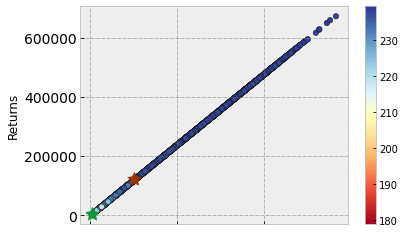

In [58]:
ax = results_df.plot(kind='scatter',x='stddev',y='return', s=30,
                     c=results_df.sharpe, cmap='RdYlBu', edgecolors='.1')
ax.grid(False, color='#777777', linestyle='-.', linewidth=0.5)
ax.set_xlabel('Volatility')
ax.set_ylabel('Returns')
ax.tick_params(labelsize=14)

# red star for highest Sharpe Ratio
ax.scatter(max_sharpe_ratio[1],max_sharpe_ratio[0], marker=(5,1,0),color='#993300',s=200)
# green star for lowest variance 
ax.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='#009933',s=200)
plt.show()